In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import numpy as np

In [2]:
!cd COVID-19 && git pull

Already up to date.


In [20]:
df_confirmed = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [28]:
df_confirmed_pivoted = df_confirmed.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().to_frame('Cases').reset_index()
df_confirmed_pivoted = df_confirmed_pivoted.rename(columns={'level_4' : 'Date'})
df_confirmed_pivoted['Date'] = pd.to_datetime(df_confirmed_pivoted['Date'])
df_confirmed_pivoted = df_confirmed_pivoted.groupby(['Country/Region','Date'])['Cases'].sum().to_frame('Cases').reset_index()

# Test for Exponential growth

In [29]:
def model(t, a, b, c): 
    return a+np.exp(b*t+c)

def fit_model(df):

    ydata=df['Cases']
    xdata=df.index

    popt, pcov = scipy.optimize.curve_fit(model, xdata, ydata,p0=[1,1,1], method='trf', max_nfev=50000)

    r_square = 1 - np.square(ydata-model(xdata, *popt)).sum() / (np.var(ydata) * len(ydata))
    
    return popt, pcov, r_square

def print_fit_results(popt, pcov, r_square):
    
    print('Fit Parameters:')
    print(popt)
    print()
    print('Covariance matrix:')
    print(pcov)
    print()
    print('R-square: %.3f'% r_square)
    
def draw_fit_results(df, popt, pcov, r_square, logy=False):

    df=df.copy()
    
    df['Model'] = model(df.index, *popt)
    
    _,ax = plt.subplots(figsize=(10,5))
    
    df.plot('Date', 'Cases', marker='o', linestyle="None", ax=ax, logy=logy)
    
    df.plot('Date', 'Model', color='k', linestyle='--', label='Exp. Model, R-square: %.3f'% r_square, ax=ax)

    forecast_index = np.array([df.index[-1], df.index[-1]+1])
    df_forecast = pd.DataFrame(
        index=forecast_index,
        data={
            'Date': pd.date_range(start=df['Date'].max(), periods=2),
            'Forecast' : model(forecast_index, *popt)
         }
    )
    
    df_forecast.plot('Date', 'Forecast', color='r', style='--', 
                     label='1 day ahead forecast: %d cases' % df_forecast.Forecast.values[-1], 
                     ax=ax)
    
    ax.legend(loc='upper left')
    ax.margins(0.05,0.05) 
    
    formatter = matplotlib.ticker.ScalarFormatter()
    formatter.set_scientific(True)
    ax.yaxis.set_minor_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    
    from datetime import datetime    
    plt.title('%s, %s' %(datetime.today().strftime('%d-%m-%Y'),df['Country/Region'].values[0]))
    plt.grid(axis='both',which='both')
    plt.show()

## Italy

Fit Parameters:
[-86.43309854   0.1998145   -0.32699014]

Covariance matrix:
[[ 9.64231532e+02  5.46991298e-02 -2.70500990e+00]
 [ 5.46991298e-02  1.23703782e-05 -5.88688750e-04]
 [-2.70500990e+00 -5.88688750e-04  2.80865154e-02]]

R-square: 0.997


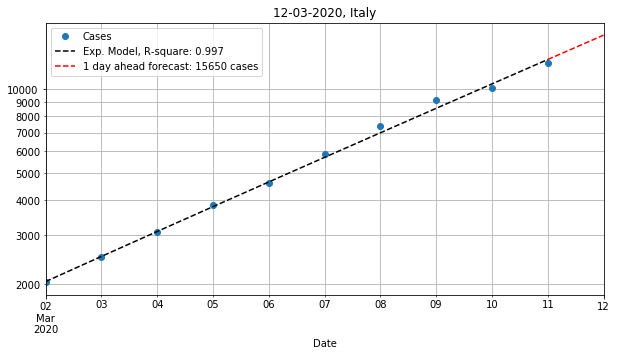

In [30]:
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
popt, pcov, r_square = fit_model(dfit)
print_fit_results(popt, pcov, r_square)
draw_fit_results(dfit[-10:], popt, pcov, r_square, logy=True)

## France

Fit Parameters:
[-1.3292628   0.26898401 -5.43716696]

Covariance matrix:
[[ 4.93354441e+01  2.05539831e-02 -1.01605011e+00]
 [ 2.05539831e-02  4.86796515e-05 -2.33271160e-03]
 [-1.01605011e+00 -2.33271160e-03  1.11941837e-01]]

R-square: 0.993


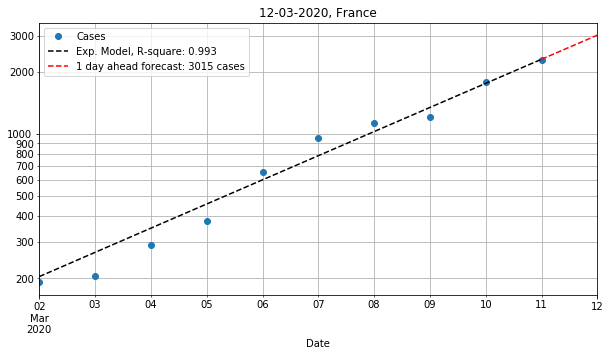

In [32]:
dffr = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'France'].reset_index(drop=True)
popt, pcov, r_square = fit_model(dffr)
print_fit_results(popt, pcov, r_square)
draw_fit_results(dffr[-10:], popt, pcov, r_square, logy=True)

## Switzerland

Fit Parameters:
[-3.71624251  0.25999507 -6.24612308]

Covariance matrix:
[[ 4.86362287e+00  6.85317840e-03 -3.38790288e-01]
 [ 6.85317840e-03  5.27654518e-05 -2.52650495e-03]
 [-3.38790288e-01 -2.52650495e-03  1.21158032e-01]]

R-square: 0.991


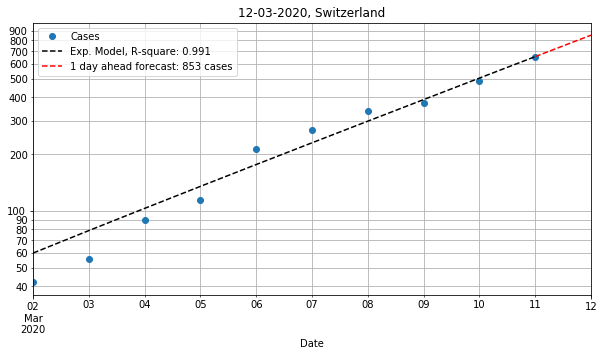

In [33]:
dfch = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Switzerland'].reset_index(drop=True)
popt, pcov, r_square = fit_model(dfch)
print_fit_results(popt, pcov, r_square)
draw_fit_results(dfch[-10:], popt, pcov, r_square, logy=True)

## China

Fit Parameters:
[-3.96723392e+08  5.08931622e-06  1.97987541e+01]

Covariance matrix:
[[ 3.52622026e-28 -4.23903382e-21  1.39893999e-19]
 [-4.23903382e-21  6.86361329e-14 -1.68173091e-12]
 [ 1.39893999e-19 -1.68173091e-12  5.54994568e-11]]

R-square: 0.889


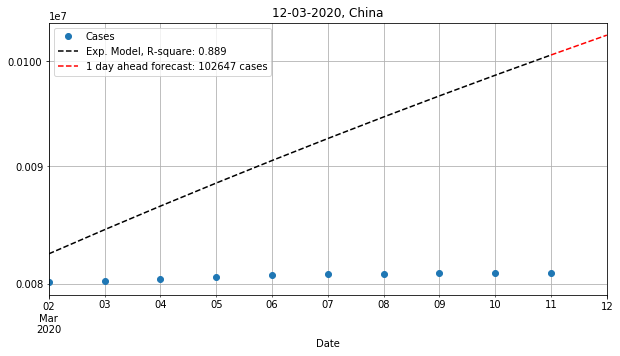

In [22]:
dfci = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'China']

# Must group over subregions
dfci = dfci.groupby('Date')['Cases'].sum().to_frame('Cases').reset_index()
dfci['Country/Region'] = 'China'


popt, pcov, r_square = fit_model(dfci)
print_fit_results(popt, pcov, r_square)
draw_fit_results(dfci[-10:], popt, pcov, r_square, logy=True)